# Exercise: Cache Bandwidths

In this exercise you will benchmark a **Schoenauer triad** kernel (i.e. `y[i] = a[i] * x[i] + y[i]`) and see how the observed performance is effected by the memory hierarchy, i.e. different cache levels.

**Hint:** On most systems, you can programmatically query the cache sizes via

```julia
using CpuId
cachesize()
```

(It doesn't work on Apple silicon.)

## Tasks

1) Inspect the code below and implement the missing piece (look for the single TODO annotation).

In [1]:
using Plots
using BenchmarkTools
using CpuId
using Statistics

"""
SDAXPY: `y[i] = a[i] * x[i] + y[i]` (Schoenauer triad without write-allocate.)

The arguments `y, a, x` are vectors of length `n`.
"""
function sdaxpy!(y, a, x, n)
    for i in 1:n
        @inbounds y[i] = a[i] * x[i] + y[i]
    end
end

"""
    vector_lengths(lo::Integer, hi::Integer, ni::Integer; factor::Integer=32)

Given some lower (`lo`) and upper (`hi`) bound in bytes, returns ≤ ni distinct integers
that are
- more or less evenly separated between lo and hi
- multiples of `factor`

These integers are to be used as vector lengths for the inputs to `sdaxpy!` and determine
the number of loop iterations therein.
"""
function vector_lengths(lo::Integer, hi::Integer, ni::Integer; factor::Integer=32)
    r_log = range(log10(lo / 32), log10(hi / 32), ni)
    r = round.(Integer, exp10.(r_log))
    r_factor = r .& (~(factor-1)) # biggest multiple of factor <= number
    return unique(r_factor)
end

"""
Perform a benchmark of the SDAXPY kernel (Schoenauer triad without write-allocate).
See `vector_lengths` for explanations of the input arguments.
"""
function bench(lo, hi, n; nbench, kwargs...)
    ts = Float64[]
    Ns = vector_lengths(lo, hi, n; kwargs...)
    for n in Ns
        y = fill(1.2, n)
        a = fill(0.8, n)
        x = fill(3.14, n)
        t = @belapsed for i in 1:$nbench
            sdaxpy!($y, $a, $x, $n)
        end samples = 30
        push!(ts, t / nbench)
        println("finished n = $n, time: ", ts[end], " sec bandwidth: ", 32.0e-9 * n / ts[end], " GB/s")
        flush(stdout)
    end
    return Ns, ts
end

function plot_results(Ns, ts)
    p = plot(Ns, Ns ./ ts .* 32.0e-9, marker=:circle, label="sdaxpy!", frame=:box, ms=2, xscale=:log10)
    ylabel!(p, "bandwidth [GB/s]")
    xlabel!(p, "vector size n")
    L1, L2, L3 = cachesize()
    mem = 4 * sizeof(Float64) # four arrays a, b, c, and d in `sdaxpy!`
    nL1 = L1 / mem
    nL2 = L2 / mem
    nL3 = L3 / mem
    vline!(p, [nL1], color=:orange, lw=2, label="L1 = $(floor(Int, nL1)) ($(L1/1024) KiB)")
    vline!(p, [nL2], color=:red, lw=2, label="L2 = $(floor(Int, nL2)) ($(L2/1024) KiB)")
    vline!(p, [nL3], color=:purple, lw=2, label="L3 = $(floor(Int, nL3)) ($(L3/1024) KiB)")
    return p
end

"""
Will perform the benchmark and save a plot of the results as png/svg files.
"""
function main()
    L1, L2, L3 = cachesize()
    Ns1, ts1 = bench(1024, L1, 12; nbench=2^24, factor=32)
    Ns2, ts2 = bench(round(Integer, L1 * 1.5), L2, 10; nbench=2^14, factor=64)
    Ns3, ts3 = bench(round(Integer, L2 * 1.5), L3, 10; nbench=2^10, factor=128)
    Ns4, ts4 = bench(round(Integer, L3 * 1.5), L3 * 32, 8; nbench=2^4, factor=64)
    p = plot_results(vcat(Ns1, Ns2, Ns3, Ns4), vcat(ts1, ts2, ts3, ts4))
    # savefig(p, "sdaxpy_contiguous.svg")
    println("L1 bandwidth:\t", round(median(32.0e-9 .* Ns1 ./ ts1); digits=2), " GB/s")
    println("L2 bandwidth:\t", round(median(32.0e-9 .* Ns2 ./ ts2); digits=2), " GB/s")
    println("L3 bandwidth:\t", round(median(32.0e-9 .* Ns3 ./ ts3); digits=2), " GB/s")
    println("Memory bandwidth:\t", round(median(32.0e-9 .* Ns4 ./ ts4); digits=2), " GB/s")
    return p
end

main

2) Run the benchmark by calling the `main()` function. (Note that this can take up to ~7 minutes.)

finished n = 32, time: 5.739476203918457e-9 sec bandwidth: 178.41349343009637 GB/s
finished n = 64, time: 1.0396922409534455e-8 sec bandwidth: 196.98136807502672 GB/s
finished n = 96, time: 1.4843960583209992e-8 sec bandwidth: 206.9528535042555 GB/s
finished n = 128, time: 1.9639043390750885e-8 sec bandwidth: 208.5641300598701 GB/s
finished n = 192, time: 2.9040196597576143e-8 sec bandwidth: 211.56881563648963 GB/s
finished n = 288, time: 4.693432104587555e-8 sec bandwidth: 196.35950397560669 GB/s
finished n = 384, time: 6.142171204090119e-8 sec bandwidth: 200.05954884190348 GB/s
finished n = 544, time: 9.308502465486527e-8 sec bandwidth: 187.01182133801086 GB/s
finished n = 736, time: 1.1680996710062027e-7 sec bandwidth: 201.62662985524406 GB/s
finished n = 1024, time: 1.6704680925607682e-7 sec bandwidth: 196.1605860412923 GB/s
finished n = 1536, time: 3.923617553710937e-7 sec bandwidth: 125.2721482844634 GB/s
finished n = 1792, time: 4.825265502929688e-7 sec bandwidth: 118.8411289807

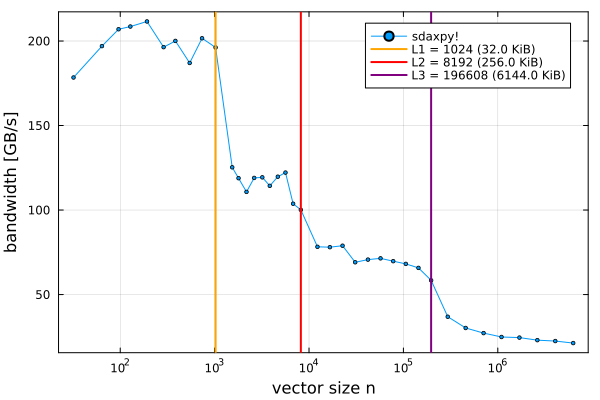

In [2]:
@time main()

* **Questions**
  * Do you understand the trend of the resulting plot?
  * Which bandwidth estimates (in GB/s) do you obtain for L1, L2, L3, and main memory? (Check the textual output of the benchmark.) Fill out the table below.
  
|  measurements   |  bandwidth [GB/s] |
|:---------------:|:-----------------:|
|  L1D cache      |  TODO              |
|  L2  cache      |  TODO              |
|  L3  cache      |  TODO              |
|  main memory    |  TODO               |


Let's now investigate the performance impact of **strided data access** in comparison to the contiguous data access (as benchmarked above).

3) Copy the entire code from above in the cell below and modify the `sdaxpy!` function such that it only performs the SDAXPY computation to every other vector element (i.e. instead of `1:n` you iterate over `1:2:n`). This corresponds to a stride size of 2.

4) Since we now only perform half as many operations and thus only half of the data transfer, we need to account for this change in all bandwidth computations. Specifically, check all lines that contain `32.0e-09` and insert an extra factor of 0.5.

In [1]:
# ...
using Plots
using BenchmarkTools
using CpuId
using Statistics

"""
SDAXPY: `y[i] = a[i] * x[i] + y[i]` (Schoenauer triad without write-allocate.)

The arguments `y, a, x` are vectors of length `n`.
"""
function sdaxpy!(y, a, x, n)
    for i in 1:2:n
        @inbounds y[i] = a[i] * x[i] + y[i]
    end
end

"""
    vector_lengths(lo::Integer, hi::Integer, ni::Integer; factor::Integer=32)

Given some lower (`lo`) and upper (`hi`) bound in bytes, returns ≤ ni distinct integers
that are
- more or less evenly separated between lo and hi
- multiples of `factor`

These integers are to be used as vector lengths for the inputs to `sdaxpy!` and determine
the number of loop iterations therein.
"""
function vector_lengths(lo::Integer, hi::Integer, ni::Integer; factor::Integer=32)
    r_log = range(log10(lo / 32), log10(hi / 32), ni)
    r = round.(Integer, exp10.(r_log))
    r_factor = r .& (~(factor-1)) # biggest multiple of factor <= number
    return unique(r_factor)
end

"""
Perform a benchmark of the SDAXPY kernel (Schoenauer triad without write-allocate).
See `vector_lengths` for explanations of the input arguments.
"""
function bench(lo, hi, n; nbench, kwargs...)
    ts = Float64[]
    Ns = vector_lengths(lo, hi, n; kwargs...)
    for n in Ns
        y = fill(1.2, n)
        a = fill(0.8, n)
        x = fill(3.14, n)
        t = @belapsed for i in 1:$nbench
            sdaxpy!($y, $a, $x, $n)
        end samples = 30
        push!(ts, t / nbench)
        println("finished n = $n, time: ", ts[end], " sec bandwidth: ", 32.0e-9 * n / ts[end], " GB/s")
        flush(stdout)
    end
    return Ns, ts
end

function plot_results(Ns, ts)
    p = plot(Ns, Ns ./ ts .* 32.0e-9, marker=:circle, label="sdaxpy!", frame=:box, ms=2, xscale=:log10)
    ylabel!(p, "bandwidth [GB/s]")
    xlabel!(p, "vector size n")
    L1, L2, L3 = cachesize()
    mem = 4 * sizeof(Float64) # four arrays a, b, c, and d in `sdaxpy!`
    nL1 = L1 / mem
    nL2 = L2 / mem
    nL3 = L3 / mem
    vline!(p, [nL1], color=:orange, lw=2, label="L1 = $(floor(Int, nL1)) ($(L1/1024) KiB)")
    vline!(p, [nL2], color=:red, lw=2, label="L2 = $(floor(Int, nL2)) ($(L2/1024) KiB)")
    vline!(p, [nL3], color=:purple, lw=2, label="L3 = $(floor(Int, nL3)) ($(L3/1024) KiB)")
    return p
end

"""
Will perform the benchmark and save a plot of the results as png/svg files.
"""
function main()
    L1, L2, L3 = cachesize()
    Ns1, ts1 = bench(1024, L1, 12; nbench=2^24, factor=32)
    Ns2, ts2 = bench(round(Integer, L1 * 1.5), L2, 10; nbench=2^14, factor=64)
    Ns3, ts3 = bench(round(Integer, L2 * 1.5), L3, 10; nbench=2^10, factor=128)
    Ns4, ts4 = bench(round(Integer, L3 * 1.5), L3 * 32, 8; nbench=2^4, factor=64)
    p = plot_results(vcat(Ns1, Ns2, Ns3, Ns4), vcat(ts1, ts2, ts3, ts4))
    # savefig(p, "sdaxpy_contiguous.svg")
    println("L1 bandwidth:\t", round(median(32.0e-9 .* Ns1 ./ ts1); digits=2), " GB/s")
    println("L2 bandwidth:\t", round(median(32.0e-9 .* Ns2 ./ ts2); digits=2), " GB/s")
    println("L3 bandwidth:\t", round(median(32.0e-9 .* Ns3 ./ ts3); digits=2), " GB/s")
    println("Memory bandwidth:\t", round(median(32.0e-9 .* Ns4 ./ ts4); digits=2), " GB/s")
    return p
end

main

5) Run the benchmark for the strided SDAXPY. How do the results compare to the contiguous case? What's the reason?

finished n = 32, time: 1.19173344373703e-8 sec bandwidth: 85.92525496212873 GB/s
finished n = 64, time: 2.2651589572429658e-8 sec bandwidth: 90.41308087679285 GB/s
finished n = 96, time: 3.222620290517807e-8 sec bandwidth: 95.32615459038132 GB/s
finished n = 128, time: 4.1712601602077484e-8 sec bandwidth: 98.1957452348405 GB/s
finished n = 192, time: 6.963583397865295e-8 sec bandwidth: 88.23043609822294 GB/s
finished n = 288, time: 9.76568044424057e-8 sec bandwidth: 94.37130420784197 GB/s
finished n = 384, time: 1.2806492257118225e-7 sec bandwidth: 95.95133275600872 GB/s
finished n = 544, time: 1.766302133798599e-7 sec bandwidth: 98.55618507668592 GB/s
finished n = 736, time: 2.5132704800367353e-7 sec bandwidth: 93.71056632016683 GB/s
finished n = 1024, time: 3.2394495421648023e-7 sec bandwidth: 101.15298779465594 GB/s
finished n = 1536, time: 6.36732421875e-7 sec bandwidth: 77.194121598616 GB/s
finished n = 1792, time: 7.255457763671875e-7 sec bandwidth: 79.03567475386845 GB/s
finishe

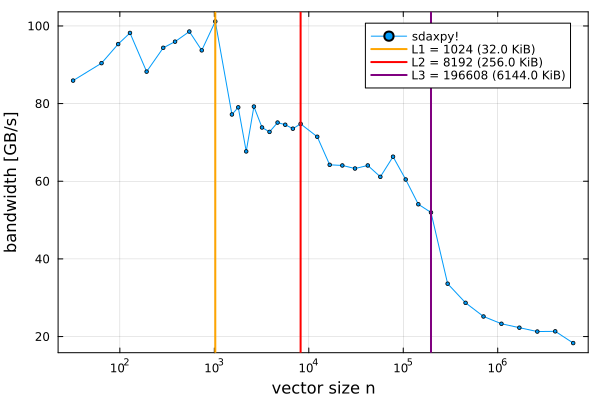

In [2]:
@time main()